In [1]:
import shap
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

/Users/anushkachougule/Desktop/inst750-final-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load trained model
best_xgb = joblib.load("../models/best_xgb_model.pkl")
print("Model loaded.")

Model loaded.


In [5]:
# Load clean and processed dataset

df = pd.read_csv("../data/processed_with_bert_score.csv")

# Add engineered features
df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']
df['installment_ratio'] = df['installment'] / (df['annual_inc'] / 12)


/var/folders/1n/k2rpq0810dl2zgrrw3bk2tlw0000gn/T/ipykernel_17751/2049671946.py:3: DtypeWarning: Columns (123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed_with_bert_score.csv")


In [6]:
# Define Feature Lists
numerical_features = [
    'sentiment_score',
    'readability_score',
    'income_to_loan',
    'loan_amnt',
    'installment',
    'annual_inc',
    'dti',
    'bert_risk_score',
    'revol_util',
    'open_acc',
    'pub_rec',
    'total_acc',
    'loan_to_income',
    'installment_ratio'
]

categorical_features = ['emp_length', 'home_ownership', 'purpose', 'term']
target = 'loan_status_binary'


In [7]:
# Drop NAs
df = df[numerical_features + categorical_features + [target]].dropna()

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Clean column names for compatibility
df.columns = df.columns.str.replace('[\[\]<>()]', '_', regex=True)

# Split into X and y
X = df.drop(columns=[target])
y = df[target]

# Train-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert scaled arrays back to DataFrames with original feature names
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)



<>:8: SyntaxWarning: invalid escape sequence '\['
<>:8: SyntaxWarning: invalid escape sequence '\['
/var/folders/1n/k2rpq0810dl2zgrrw3bk2tlw0000gn/T/ipykernel_17751/326301013.py:8: SyntaxWarning: invalid escape sequence '\['
  df.columns = df.columns.str.replace('[\[\]<>()]', '_', regex=True)


In [8]:
# Use TreeExplainer for XGBoost
explainer = shap.Explainer(best_xgb, X_test)
shap_values = explainer(X_test)

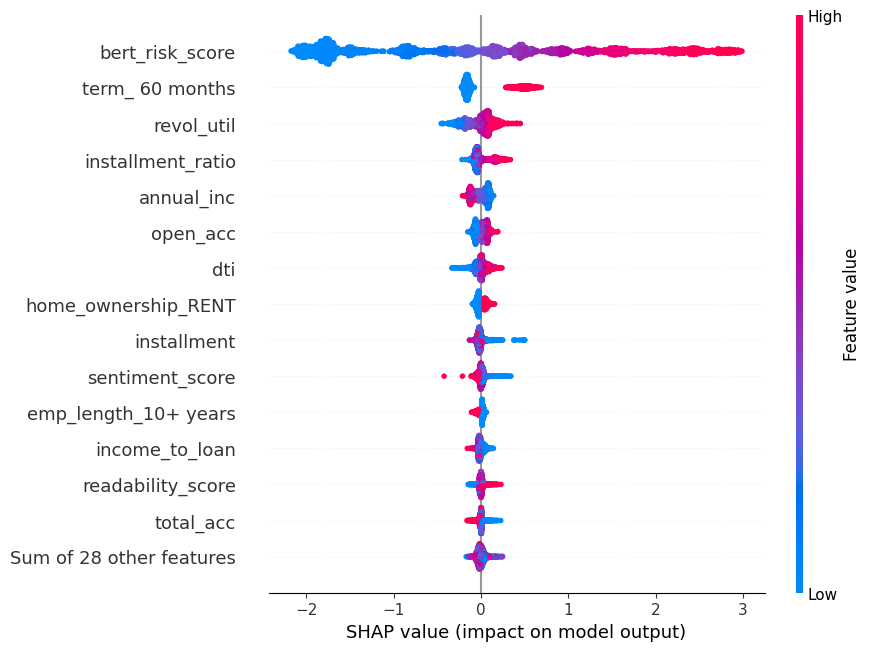

In [ ]:
# Visualize Beeswarm plot
shap.plots.beeswarm(shap_values, max_display=15)

The above beeswarm plot visualizes the impact of each feature on the model’s output across all test samples. Each dot represents a loan application.
- 'bert_risk_score' is by far the most influential feature. Higher values (in red) push predictions toward default, while lower values (in blue) reduce default risk.
- Features like 'term_60 months', 'revol_util', and 'installment_ratio' also contribute significantly to the model's decisions.
- The plot clearly shows how both structured features and the BERT-derived risk score interact to inform the model's behavior.

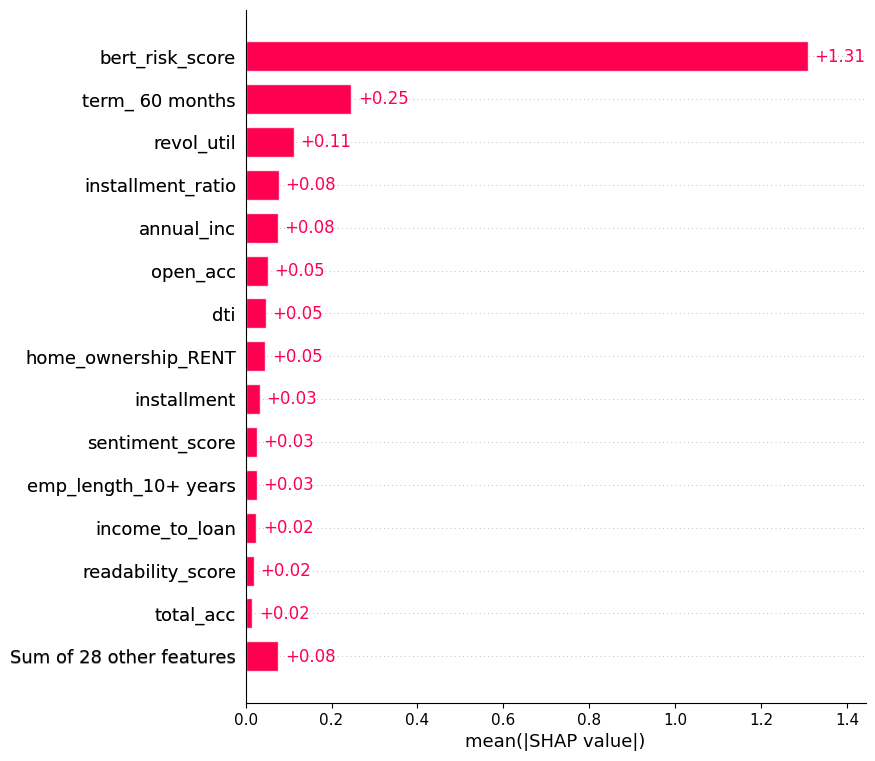

In [ ]:
# Visualize bar plot
shap.plots.bar(shap_values, max_display=15)

The above bar plot shows the average magnitude of each feature’s SHAP value i.e. a measure of overall importance to the model.

- 'bert_risk_score' has the highest average impact by a wide margin, confirming the effectiveness of using fine-tuned BERT on borrower narratives.
- Traditional financial features such as 'term_60 months', 'revol_util', and 'annual_inc' also have meaningful influence.
- This reinforces that combining unstructured narrative insights with structured financial data results in a more powerful predictive model.

In [ ]:
# Force plot for non-defaulter
shap.initjs()
shap.plots.force(shap_values[0])

The above force plot shows how the model arrived at a prediction for one specific borrower.

- The model predicted a **low probability of default (f(x) = -0.80)**.
- The 'bert_risk_score' pushed the prediction slightly upward toward default (positive SHAP value).
- However, multiple strong signals — such as **low 'revol_util'**, **short loan term**, **high income**, and **low 'installment_ratio'** — contributed to **pulling the prediction back toward non-default**.
- This plot clearly illustrates how a combination of **structured financial indicators** outweighed the unstructured risk signal from BERT in this case.

In [9]:
# Force plot for defaulter
shap.plots.force(shap_values[10])

The above force plot explains a prediction where the model assigned a **high risk of default (f(x) = 1.25)**.

- The 'bert_risk_score' was moderately high (0.4864), indicating the narrative raised concern.
- Financial risk factors further amplified the default prediction:
  - A **60-month loan term** had strong positive influence (+1.644)
  - High **DTI (debt-to-income ratio)** and lower **annual income** also pushed the score up
  - A moderately high number of **open accounts** (0.6669) added to risk

- Only one feature, **home_ownership = RENT**, slightly reduced the score, but not enough to offset the stacked risk factors.

This shows how the model combines unstructured narrative signals with multiple financial red flags to identify high-risk borrowers.
